Initial exploratory data analysis for PH predictor module.

In [22]:
import xcf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter

Load raw data and show columns.

In [2]:
raw_data = pd.read_csv('../data/raw/data_raw_2022-11-06.csv')
raw_data.columns

Index(['Unnamed: 0', 'matthews', 'percent_solvent', 'rcsb_id', 'method', 'pH',
       'conditions', 'temp', 'resolution', 'organism', 'sequence'],
      dtype='object')

Select columns relevant for pH prediction, check info to see if general size and number of NaNs.

In [3]:
proc_data = raw_data[['rcsb_id', 'pH', 'sequence']]
proc_data = proc_data.set_index('rcsb_id')
proc_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123352 entries, 101M to 9XIM
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   pH        95672 non-null   float64
 1   sequence  122948 non-null  object 
dtypes: float64(1), object(1)
memory usage: 2.8+ MB


Drop NaNs, chenge sequence dtype to string. Calculate seqence length. Visualize pH and length distribution.

                 pH       len_seq
count  95672.000000  95672.000000
mean       6.776959    299.193933
std        1.303877    171.265304
min        0.000000      4.000000
5%         4.500000     99.000000
50%        7.000000    274.000000
95%        8.500000    595.000000
max       12.000000   4128.000000


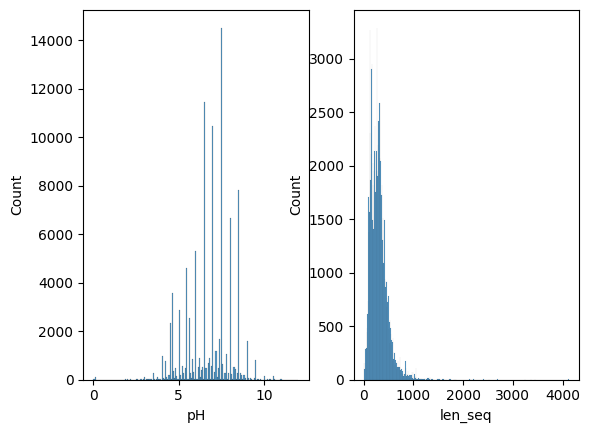

In [4]:
proc_data = proc_data.dropna()
proc_data['sequence'] = proc_data['sequence'].astype('string')
proc_data['len_seq'] = proc_data['sequence'].map(len)
print(proc_data.describe(percentiles=[0.05,0.95]))
fig, axes = plt.subplots(1,2)
sns.histplot(data=proc_data, x='pH', ax=axes[0])
sns.histplot(data=proc_data, x='len_seq',ax=axes[1])
plt.show()

Drop pH lower than 3 and higher than 10 (based on available screens and expertise). Drop sequences shorter than 100 and longer than 600 - approx. based on 0.05 and 0.95 percentiles.

                 pH       len_seq
count  85682.000000  85682.000000
mean       6.778237    285.284190
std        1.266922    117.697687
min        3.000000    100.000000
5%         4.500000    123.000000
50%        7.000000    275.000000
95%        8.500000    505.000000
max       10.000000    600.000000


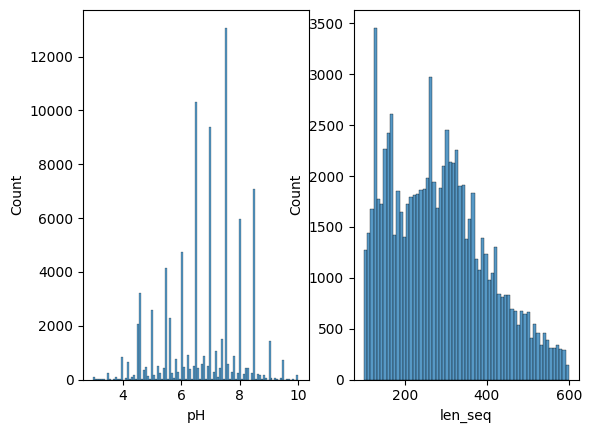

In [5]:
proc_data = proc_data[(proc_data['pH'] >= 3) & (proc_data['pH'] <= 10)]
proc_data = proc_data[(proc_data['len_seq'] >= 100) & (proc_data['len_seq'] <= 600)]
print(proc_data.describe(percentiles=[0.05,0.95]))
fig, axes = plt.subplots(1,2)
sns.histplot(data=proc_data, x='pH', ax=axes[0])
sns.histplot(data=proc_data, x='len_seq',ax=axes[1])
plt.show()

Check for non-standard AA in sequences.

In [6]:
one_big_string =''.join(proc_data['sequence'])
char_counts = {c:one_big_string.count(c) for c in set(one_big_string)}
for key, value in sorted(char_counts.items()):
    print(f'{key} : {value}')

A : 1990038
B : 15
C : 333512
D : 1414470
E : 1587786
F : 982499
G : 1848001
H : 719676
I : 1359615
K : 1402189
L : 2236773
M : 584511
N : 1011101
O : 4
P : 1141606
Q : 890442
R : 1215459
S : 1504701
T : 1333165
U : 18
V : 1705362
W : 336156
X : 4752
Y : 841845
Z : 24


In [28]:
def classify_acidity(x):
    if x <= 7.0:
        return 0
    elif x > 7.0:
        return 1

data = xcf.load_data_from_db('data_pHpred_from_data_raw_2023-04-07', mode = 'clean')
data = data[['sequence', 'pH']]
data['acidity'] = data['pH'].apply(classify_acidity)
data.head()

,sequence,pH,acidity
rcsb_id,,,
4BOB,GAMGDEQSSGEINHTLYDEQSNGELKLKKIEFSKFTVKIKNKDNNS...,7.5,1
4BOD,GAMGDGQSNGEAKVKKIEFSEFTVKIKNKNNSNNWADLGDLVVRKE...,7.5,1
4BOF,MTAQTPIHVYSEIGKLKKVLLHRPGKEIENLMPDYLERLLFDDIPF...,5.5,0
4BPD,GHHHHHHELANNTTGFTRIIKAAGYSWKGLRAAWINEAAFRQEGVA...,5.6,0
4BPM,MHHHHHHSPALPAFLLCSTLLVIKMYVVAIITGQVRLRKKAFANPE...,6.7,0


In [36]:
AA_VOCAB = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

for aa in AA_VOCAB:
    
    data[f'No {aa}'] = data['sequence'].apply(lambda s: s.count(aa)/len(s)*100)

avg_aa_ratio = []
for aa in AA_VOCAB:
    avg_aa_ratio.append(data[f'No {aa}'].groupby(data['acidity']).mean())

avg_ratio_diff = [aa[0]-aa[1] for aa in avg_aa_ratio]
avg_ratio_diff

[-0.0479377194610473,
 -9.949154202451907e-05,
 0.008913026963473847,
 0.01677253233350484,
 -0.011188219638130548,
 0.01566053882482077,
 -0.03159001997978894,
 0.00365976532692347,
 -0.009478623992317026,
 -0.002415283730775819,
 0.0030938997509242228,
 -0.001938691012244309,
 -0.014495859097786834,
 -6.995925228442066e-06,
 -0.017423736427459424,
 -0.017276069161395124,
 -0.01430440760047258,
 0.07329503754093114,
 0.06014625154280129,
 0.00018309261618940152,
 -0.013678145622278315,
 -0.00018996041229435434,
 -0.008308929705251359,
 0.008757437497857623,
 -0.0001494290889326441]

In [67]:
position_counts_acidic = np.zeros(shape=(600, len(AA_VOCAB)), dtype='int')
position_counts_basic = np.zeros(shape=(600, len(AA_VOCAB)), dtype='int')
acidic_seq = data['sequence'][data['acidity'] == 0].to_list()
basic_seq = data['sequence'][data['acidity'] == 1].to_list()

for seq in acidic_seq:
    for i, aa in enumerate(seq):
        position_counts_acidic[i][AA_VOCAB.index(aa)] += 1

for seq in basic_seq:
    for i, aa in enumerate(seq):
        position_counts_basic[i][AA_VOCAB.index(aa)] += 1


In [66]:
data['acidity'].value_counts()

0    50367
1    36815
Name: acidity, dtype: int64

In [68]:
position_counts_acidic = pd.DataFrame(position_counts_acidic, columns=AA_VOCAB)
position_counts_basic = pd.DataFrame(position_counts_basic, columns=AA_VOCAB)


In [71]:
position_counts_acidic = position_counts_acidic[['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']]
position_counts_basic = position_counts_basic[['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']]
position_counts_ratio = position_counts_acidic/position_counts_basic/(50367/36815)

<AxesSubplot: >

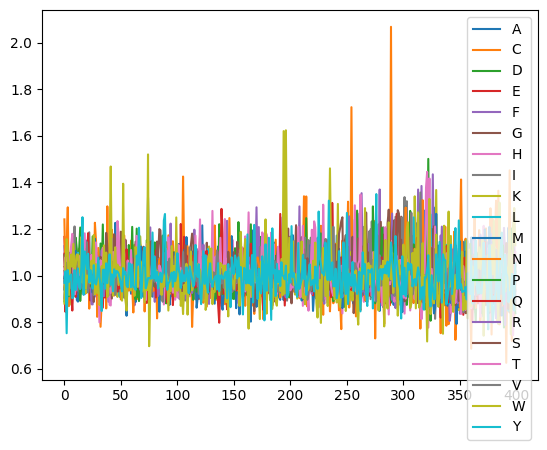

In [74]:
position_counts_ratio[:400].plot(kind='line')